# Import Statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-deep')
import seaborn as sns

# Load and Preprocess Data

### Load and reindex DataFrames:

In [2]:
steam_df = pd.read_csv('data/steam.csv')
tags_df = pd.read_csv('data/steamspy_tag_data.csv')
steam_df.set_index('appid', inplace=True)
tags_df.set_index('appid', inplace=True)

### Add useful columns to steam_df DataFrame:

Since review data is only provided as number of positive and negative reviews, we generate a column that gives the ratio of total reviews that is positive for each game:

In [3]:
steam_df['scores'] = (steam_df['positive_ratings']) / (steam_df['negative_ratings'] + steam_df['positive_ratings'])

Generate columns corresponding to the number of reviews, release year, and if the game is 'free to play' for each game:

In [4]:
steam_df['num_reviews'] = steam_df['positive_ratings'] + steam_df['negative_ratings']
steam_df['release_year'] = steam_df.apply(lambda row: row['release_date'].split('-')[0], axis = 1)
steam_df['release_year'] = steam_df['release_year'].astype('int')

Playtime statistics are given in minutes, so we change them to hours:

In [5]:
steam_df['average_playtime'] = steam_df['average_playtime'] / 60
steam_df['median_playtime'] = steam_df['median_playtime'] / 60

Since playtime statistics are cumulative from the day the game was released, we create a column that divides the cumulative average playtime by the number of years the game has been available:

In [6]:
steam_df['norm_playtime'] = steam_df['average_playtime'] / (2020 - steam_df['release_year'])

# Data Overview

### Scores

Below is a histogram of the positive score ratio for all released games:

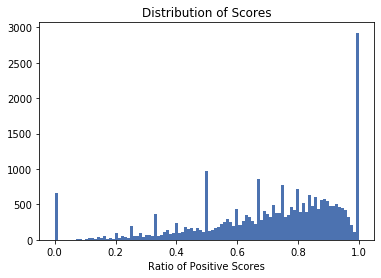

In [34]:
plt.figure()
plt.hist(steam_df['scores'].values, bins=101)
plt.xlabel('Ratio of Positive Scores')
plt.title('Distribution of Scores')
plt.show()

A further look into the games with 'perfect' reviews:

In [20]:
perfect_games = steam_df.loc[steam_df['scores'] == 1, ['name', 'scores', 'num_reviews']]
perfect_games.sort_values(by='num_reviews', ascending=False).head(7)

,name,scores,num_reviews
appid,,,
992740,祈風 Inorikaze,1.0,114
454380,Champions of Breakfast,1.0,112
790060,The Void Rains Upon Her Heart,1.0,98
473920,Corinne Cross's Dead & Breakfast,1.0,94
804700,The House in Fata Morgana: A Requiem for Innoc...,1.0,87
1047680,ALILIA-亚利利亚的精灵们,1.0,86
900270,Lonk's Adventure,1.0,86


The largest number of reviews for a 'perfect' game is only 114! Do most games have more reviews than this?

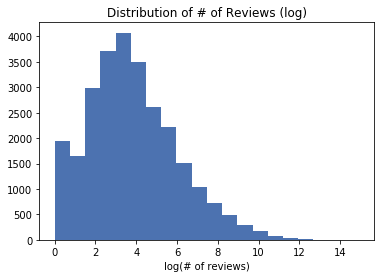

In [29]:
plt.figure()
plt.hist(np.log(steam_df['num_reviews']), bins=20)
plt.title('Distribution of # of Reviews (log)')
plt.xlabel('log(# of reviews)')
plt.show()

It seems clear that games with less that 1000 reviews are very representative of the rest. Below is the score distribution for games that have at least 1000 reviews:

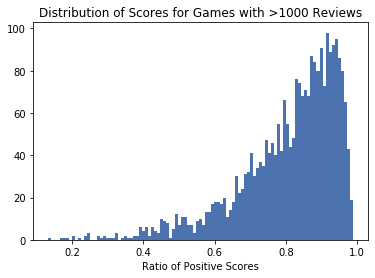

In [36]:
plt.figure()
plt.hist(steam_df.loc[steam_df['num_reviews'] >=1000, 'scores'].values, bins=101)
plt.title('Distribution of Scores for Games with >1000 Reviews')
plt.xlabel('Ratio of Positive Scores')
plt.show()

# Analysis of Game Tags

Any user who purchases a Steam game can select any number of 'tags' to associate with the game. Since these tags can be defined by the user, we see a much larger variety in tags than we do in 'genres' or 'categories,' which are defined by the developer.

First, we generate a DataFrame that combines game information with the number of each tag it has recevied:

In [42]:
all_df = pd.merge(steam_df, tags_df, on='appid')

We also generate a list with every unique tag:

In [43]:
tags = list(tags_df.columns.values)

Since tags are user-assigned, there are often tags that are incorrectly assigned to a game or that most users would not agree represents the game's content. Another issue is that popular games can receive thousands of tags while others do not, which could skew analysis towards tags associated with those popular games. In order to solve these problems, for each game we assign a '1' to tags that appear very frequently and a '0' to the 'outlier' tags. 

Note that 'frequent' tags are defined here as being those that appear with more than half the frequency of the game's most popular tag.

In [44]:
for tag in tags:
    all_df.loc[all_df[tag] >= (all_df[tags].max(axis=1) / 2), tag] = 1
    all_df.loc[all_df[tag] < (all_df[tags].max(axis=1) / 2), tag] = 0

### Change in Tags Over Time

First we determine the 20 tags that have had the largest amount of change in representation over the past 10 years:

In [54]:
years = all_df.groupby('release_year')
tag_counts = years[tags].agg(['sum'])
tag_ratio = tag_counts.div(tag_counts.sum(axis=1), axis=0)
tag_diff = tag_ratio.loc[2008:2018].max() - tag_ratio.loc[2008:2018].min()
changed_tags = tag_diff.sort_values(ascending=False).head(20).index
changed_tags = list(list(zip(*list(changed_tags)))[0])
print(changed_tags)

['indie', 'vr', 'singleplayer', 'strategy', 'third_person', 'puzzle', 'violent', 'third_person_shooter', 'turn_based_strategy', 'visual_novel', 'world_war_ii', 'hidden_object', 'story_rich', 'simulation', 'zombies', 'war', 'turn_based', 'tower_defense', 'walking_simulator', 'tactical']


Now let's see how these tag's prevalence has changed over time:

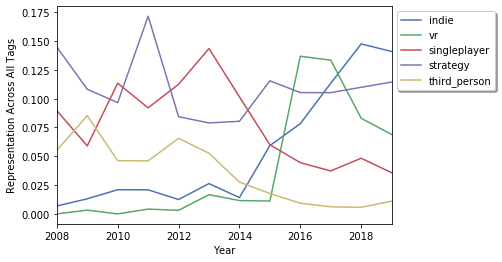

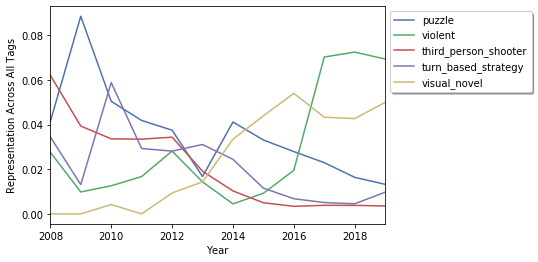

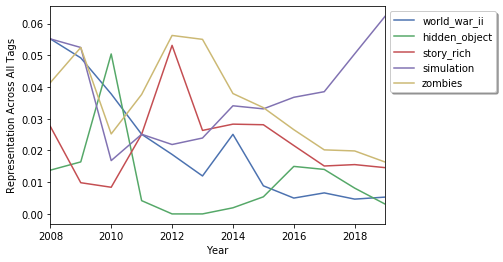

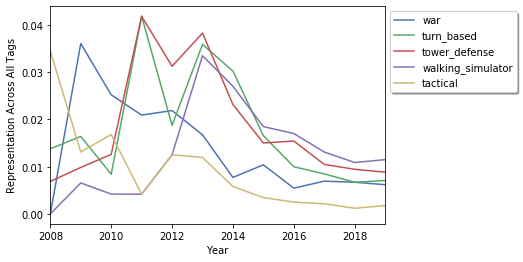

In [80]:
for n in range(0,4):
    plt.figure()
    for tag in changed_tags[n*5:n*5 + 5]:
        plt.plot(np.arange(2008, 2020), tag_ratio.loc[2008:2019][tag].values, label=tag)
    plt.xlabel('Year')
    plt.ylabel('Representation Across All Tags')
    plt.legend(loc='upper left',bbox_to_anchor=(1, 1), fancybox=True, shadow=True)
    plt.xlim((2008,2019))
    plt.show()

The rise and fall of certain game tags represent very real changes in the gaming industry. Some are more obvious, like the sharp increase in the 'vr' tag as virtual reality grows in popularity. Other changes, like the steady decrease in popularity of the 'world_war_ii' tag, are less expected.

Do these changes in tag representation also reflect a change in scoring behavior?

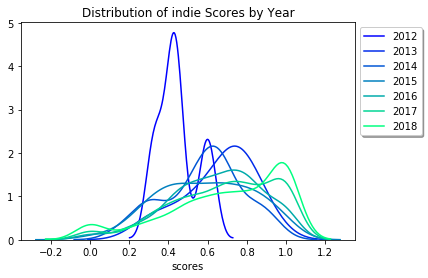

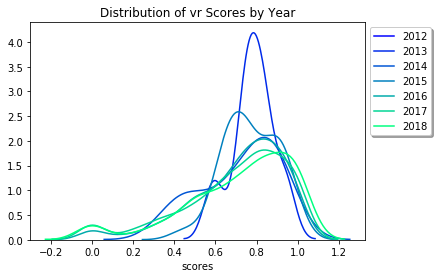

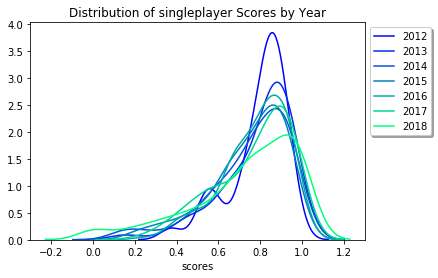

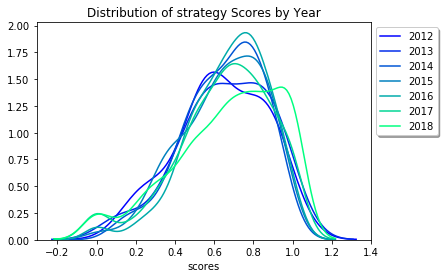

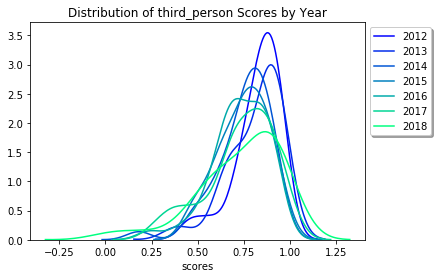

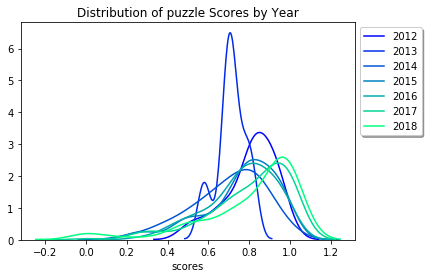

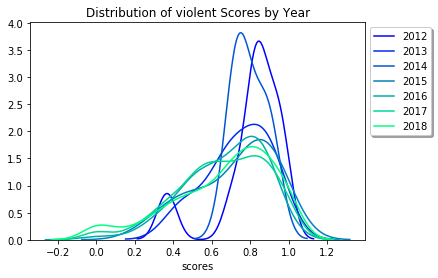

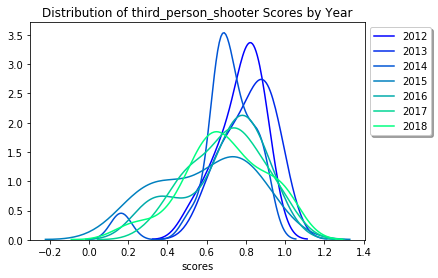

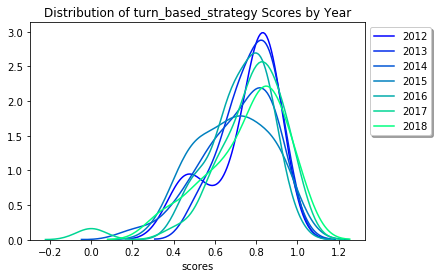

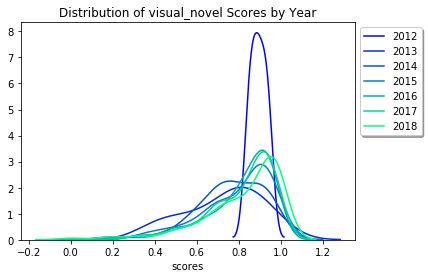

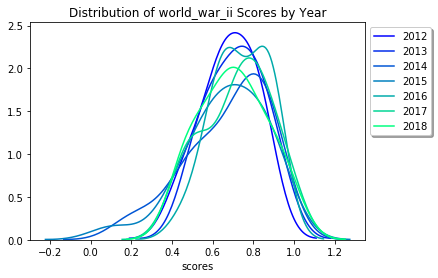

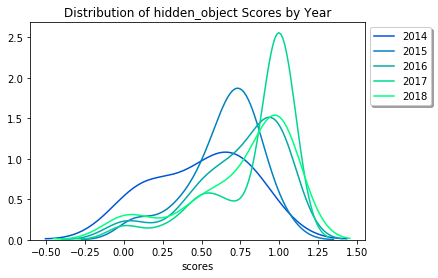

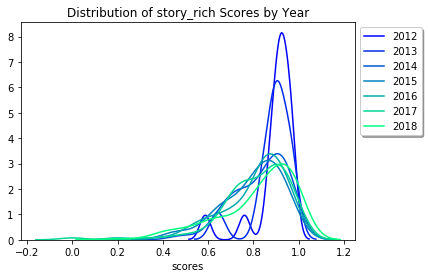

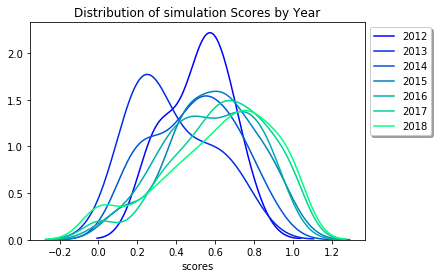

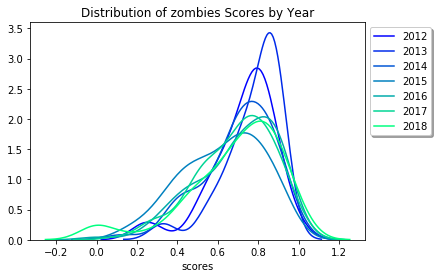

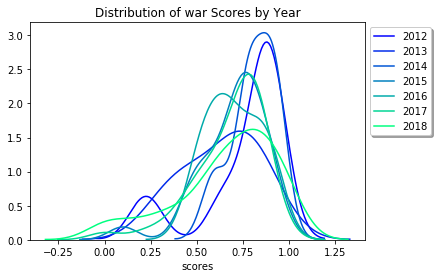

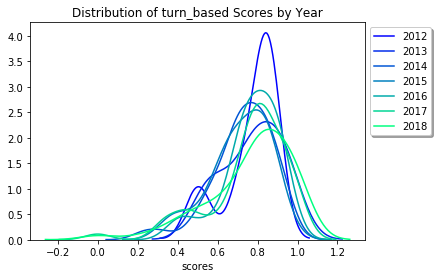

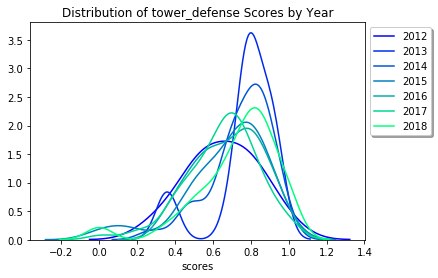

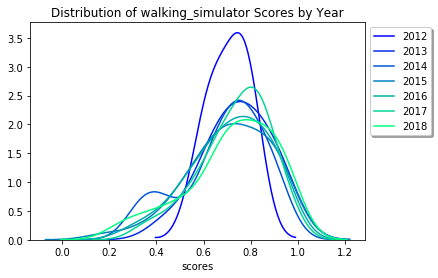

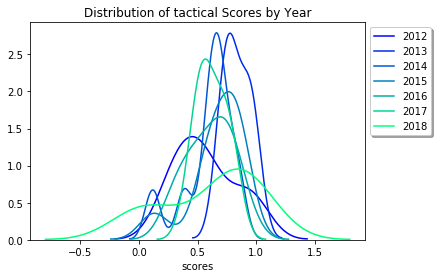

In [115]:
colors = plt.cm.winter(np.linspace(0,1,7))
for tag in changed_tags:
    plt.figure()
    for n in range(2012,2019):
        c = tuple(colors[n-2012])[0:3]
        subset = years.get_group(n)
        subset_scores = subset.loc[subset[tag] == 1]['scores']
        sns.distplot(subset_scores, bins=101, kde=True, kde_kws={'color': c}, hist=False, label='%d' % n)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), fancybox=True, shadow=True)
    plt.title('Distribution of ' + tag +  ' Scores by Year')